<a href="https://colab.research.google.com/github/lakshenoy/conference-tutorials/blob/main/Tutorial_Bochkarev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Young Researcher's Workshop on Machine Learning for Materials </center>

### <center>May 10, 2022</center> 
#### <center> CECAM-IT-SISSA </center> 

## <center> Anton Bochkarev</center> 
### <center> ICAMS, Ruhr University Bochum, Germany </center> 

# Installing

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
! python --version

In [ ]:
! pip install ase pandas

In [ ]:
! git clone https://github.com/ICAMS/python-ace.git

In [ ]:
! pip install ./python-ace/

In [ ]:
! git clone https://github.com/ICAMS/TensorPotential.git

In [ ]:
! pip install ./TensorPotential

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1pr3aq8KvYQJ9OpYpsdeiry5tWQvrNflU?usp=sharing

On Colab, restart the kernel after the installation and go directly to the next section

# Importing

In [ ]:
%pylab inline

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from ase.build import bulk, molecule
from ase.neighborlist import PrimitiveNeighborList
from ase.eos import EquationOfState
from ase.visualize import view
from ase.units import kJ

In [ ]:
from pyace import *

# Introduction

What is it the problem we want to solve?

Instead of this:
$$ H(\{Z, \mathbf R\})\xrightarrow{\Psi} E$$
We want to use this:
$$  \mathcal{F}(\{Z, \mathbf R\}, \theta)\xrightarrow{\mathbf \theta} E^*$$

And we want to "learn" $\mathcal{F}$ via minimizing a loss function:

$$\min_{\theta} \sum_i (E_i-E^*_i)^2$$

Let's take a look at some structure:

In [ ]:
acetaldehyde = molecule('CH3CHO')

In [ ]:
view(acetaldehyde, viewer='x3d')

Can't we just take atomic positions and some general function, say an ANN, and learn the energy?

In [ ]:
acetaldehyde.get_positions()

What happens if we rotate the atoms?

In [ ]:
acetaldehyde.rotate(42, 'z')
acetaldehyde.get_positions()

In [ ]:
mix = np.arange(len(acetaldehyde))
np.random.shuffle(mix)
acetaldehyde_p = acetaldehyde[mix]
acetaldehyde_p.get_positions()

It would be beneficial to represent an atomic structure in a certain way that reflects a prior knowledge of the application domain. This representation is called descriptor $D$, and now

$$  \mathcal{F}(D(\{Z, \mathbf R\}), \theta)\xrightarrow{\mathbf \theta} E^*$$

There are certain properties that we want from a descriptor:
   - Rotation and Translation invariance 
   - Permutation and Inversion invariance 
   - (preferably) Size independence

# Global descriptor: Coulomb matrix

\begin{equation}
    M_{ij}^\mathrm{Coulomb}=\left\{
        \begin{matrix}
        0.5 Z_i^{2.4} & \text{for } i = j \\
            \frac{Z_i Z_j}{R_{ij}} & \text{for } i \neq j
        \end{matrix}
        \right.
    \end{equation}

$$E = \mathcal{F}(M_{ij}^\mathrm{Coulomb})$$

In [ ]:
# Define a function for constructing a Coulomb matrix 

def build_cm(atoms, permute=False, rotate=False):
    nat = len(atoms)
    
    if permute:
        mix = np.arange(nat)
        np.random.shuffle(mix)
        atoms = atoms[mix]
        
    if rotate:
        atoms.rotate(42, 'z')
        
    cm = np.zeros((nat, nat))
    for i in range(nat):
        for j in range(nat):
            z_i = atoms[i].number
            z_j = atoms[j].number
            r_i = atoms[i].position
            r_j = atoms[j].position
            r_ij = np.linalg.norm(r_j - r_i)
            
            if i != j:
                cm[i,j] = z_i * z_j / r_ij
            else:
                cm[i,j] = 0.5 * z_i ** 2.4
    
    return cm, atoms.get_chemical_symbols()

In [ ]:
acetaldehyde = molecule('CH3CHO')

In [ ]:
cm0, s0 = build_cm(acetaldehyde)
print(s0)
np.set_printoptions(precision=2)
print(cm0)

Let's try rotating it:

In [ ]:
cm1, s1 = build_cm(acetaldehyde, rotate=True)
print(s1)
print(cm1)

Now let's mix the atom's order

In [ ]:
cm2, s2 = build_cm(acetaldehyde, permute=True)
print(s2)
print(cm2)

Can we fix it?

One would need to sort somehow the elements of this matrix

In [ ]:
np.sort(np.linalg.eigh(cm0)[0])

In [ ]:
np.sort(np.linalg.eigh(cm1)[0])

In [ ]:
np.sort(np.linalg.eigh(cm2)[0])

Variations of this descriptor for pbc:

    - Sin matrix
    - Ewald matrix

Pro:

    - Simple
    - Global
Con:

    - Simple
    - Size dependent

PRL 108, 058301 (2012),
International Journal of Quantum Chemistry 115, 1094 (2015),
Çaylak et al 2020 Mach. Learn.: Sci. Technol. 1 03LT01

# Local descriptor: Local atomic environment

Assume, that we can represent the total energy of a structure as:

$$ \Large E =  \sum_i E_i$$

An now we write an atomic energy as a function of a local atomic descriptor:

$$E_i = \mathcal{F}(D(R_c), f_c(R_c))$$

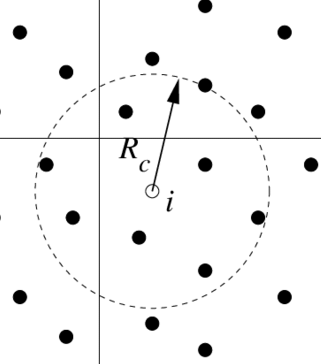

Cutoff function is neccessary for smooth behavior of $\mathcal{F}$ close to the cutoff distance

\begin{equation}
    f_{c} = \left\{
        \begin{matrix}
        0.5 \left[ cos(\frac{\pi r_{ij}}{R_c}) + 1 \right] & \text{for } r_{ij} \le R_c \\
            0 & \text{for } r_{ij} > R_c
        \end{matrix}
        \right.
    \end{equation}

In [ ]:
def f_cut(r, rc):
    fc = 0.5 * (np.cos(np.pi * r / rc) + 1)
    fc[r>rc] = 0
    
    return fc

In [ ]:
rc = 10
r = np.linspace(0, rc + 1, 100)

plt.figure(dpi=150)
plt.plot(r, f_cut(r, rc))
plt.axhline(y=0, ls='--', c='r')
plt.xlabel('r')
plt.ylabel('Cutoff function');

## Atom-centred symmetry functions

Two-body radial descriptor, that probes the region of space around $R_s$

$$ \Large G_i^2 = \sum_j e^{-\eta(r_{ij} - R_s)^2} f_c(r_{ij}) $$

In [ ]:
def g_radial(r, eta=0.1, rs=2, rc=6):
    g = np.exp(-eta * (r - rs) ** 2) * f_cut(r, rc)
    
    return g

In [ ]:
rc = 10
eta = 100
r_space = np.linspace(0, rc, 200)
r_probe = np.linspace(0, rc, 11)

In [ ]:
plt.figure(dpi=150)
for rs_i in r_probe:
    g = g_radial(r_space, eta=eta, rs=rs_i, rc=rc)
    plt.plot(r_space, g, label=f'Rs = {rs_i}')
plt.legend()
plt.ylabel('G')
plt.xlabel(r'R, $\AA$');

In [ ]:
eta_space = [0.01, 0.05, 0.1, 0.3, 0.5, 1, 2, 3]

In [ ]:
plt.figure(dpi=150)
for eta_i in eta_space:
    g = g_radial(r_space, eta=eta_i, rs=0, rc=rc)
    plt.plot(r_space, g, label=fr'$\eta$ = {eta_i}')
plt.legend()
plt.ylabel('G')
plt.xlabel(r'R, $\AA$');

#### Let's look at this descriptor for different crystall structures:

In [ ]:
# Let's define a function that builds len(rs_list) G^2 descriptors for a given structure and cutoff distance rc

def build_g2_dscrptr(atoms, rs_list, eta=1, rc=8):
    nl = PrimitiveNeighborList(cutoffs=[rc * 0.5] * len(atoms),
                              self_interaction=False, bothways=True)
    nl.update(atoms.get_pbc(), atoms.get_cell(), atoms.get_positions())
    
    g2 = []
    for i in range(len(atoms)):
        ind, off = nl.get_neighbors(i)
        
        r_i = np.take(atoms.get_positions(), [i] * len(ind), axis=0)
        r_j = np.take(atoms.get_positions(), ind, axis=0) + off @ atoms.get_cell()
        r_ij = r_j - r_i
        d_ij = np.linalg.norm(r_ij, axis=1)
        
        g = np.array([g_radial(d_ij, eta=eta, rs=rs, rc=rc) for rs in rs_list]).sum(axis=1)
        g2.append(g)
    
    return g2

In [ ]:
ng = 10
rc = 8
rs_list = np.linspace(1, rc - 0.5, ng)
eta = 10

FCC:

In [ ]:
fcc = bulk('Cu', 'fcc', a=4)
g2_fcc = build_g2_dscrptr(fcc, rs_list, eta=eta, rc=rc)

In [ ]:
plt.figure(dpi=100)
plt.plot(rs_list, g2_fcc[0], 'o-')
plt.xlabel(r'$R_s$')
plt.ylabel(r'$G_i^2$')

BCC:

In [ ]:
bcc = bulk('Cu', 'bcc', a=4)
g2_bcc = build_g2_dscrptr(bcc, rs_list, eta=eta, rc=rc)

In [ ]:
plt.figure(dpi=100)
plt.plot(rs_list, g2_bcc[0], 'o-')
plt.xlabel(r'$R_s$')
plt.ylabel(r'$G_i^2$')

Plotting together both FCC and BCC $G^2$ descriptors:

In [ ]:
plt.figure(dpi=100)
plt.plot(rs_list, g2_fcc[0], 'o-', label='FCC')
plt.plot(rs_list, g2_bcc[0], 'o-', label='BCC')
plt.xlabel(r'$R_s$')
plt.ylabel(r'$G_i^2$')
plt.legend()

Variation of the $G^2$ descriptor with lattice parameter of an FCC structure:

In [ ]:
plt.figure(dpi=100)
for a in [2.5, 3, 3.5, 4]:
    fcc = bulk('Cu', 'fcc', a=a)
    g2_fcc = build_g2_dscrptr(fcc, rs_list, eta=eta, rc=rc)
    plt.plot(rs_list, g2_fcc[0], 'o-', label=f'a={a}')
plt.xlabel(r'$R_s$')
plt.ylabel(r'$G_i^2$')
plt.legend();

Now what about more than 2-body?
Angular 3-body symmetry function:

$$ \Large G_i^5 = 2^{1-\xi}\sum_{j,k\ne i}(1+\lambda cos\theta_{ijk})^{\xi}e^{-\eta(r_{ij}^2 + r_{ik}^2)} f_c(r_{ij})f_c(r_{ik})$$

In [ ]:
def g_ang(r_ij, r_ik, ang_jik, eta=1, xi=2, lmbda=1, rc_ij=10, rc_ik=10):
    g = 2 ** (1 - xi) * (1 + lmbda * np.cos(ang_jik / 180 * np.pi)) ** xi \
        * np.exp(-eta * (r_ij ** 2 + r_ik ** 2)) * f_cut(r_ij, rc_ij) * f_cut(r_ik, rc_ik)
    
    return g

In [ ]:
rc = 10
eta = 0.1
xi_sapce = np.linspace(1,10,10)
r_space = np.array([0])
ang_space = np.linspace(0,360,200)

In [ ]:
plt.figure(dpi=150)
for xi_i in xi_sapce:
    g = g_ang(r_space, r_space, ang_space, eta=eta, xi=xi_i, rc_ij=rc, rc_ik=rc)
    plt.plot(ang_space, g, label=fr'$\xi$ = {xi_i}')
plt.legend()
plt.ylabel('G angular')
plt.xlabel(r'$\theta$, degree');

In [ ]:
plt.figure(dpi=150)
for xi_i in xi_sapce:
    g = g_ang(r_space, r_space, ang_space, eta=eta, xi=xi_i, rc_ij=rc, rc_ik=rc, lmbda=-1)
    plt.plot(ang_space, g, label=fr'$\xi$ = {xi_i}')
plt.legend()
plt.ylabel('G angular')
plt.xlabel(r'$\theta$, degree');

Pro:

- Relatively simple
- Local, size independent

Con:

- Local
- Restricted to 2 and 3-body contributions only. Incomplete 
- 3-body symmetry functions require building atomic triplets explicitly 

J.Chem.Phys. 134, 074106 (2011), Phys. Rev. Lett. 98, 146401 (2007)

# The Zoo of Structural Representations

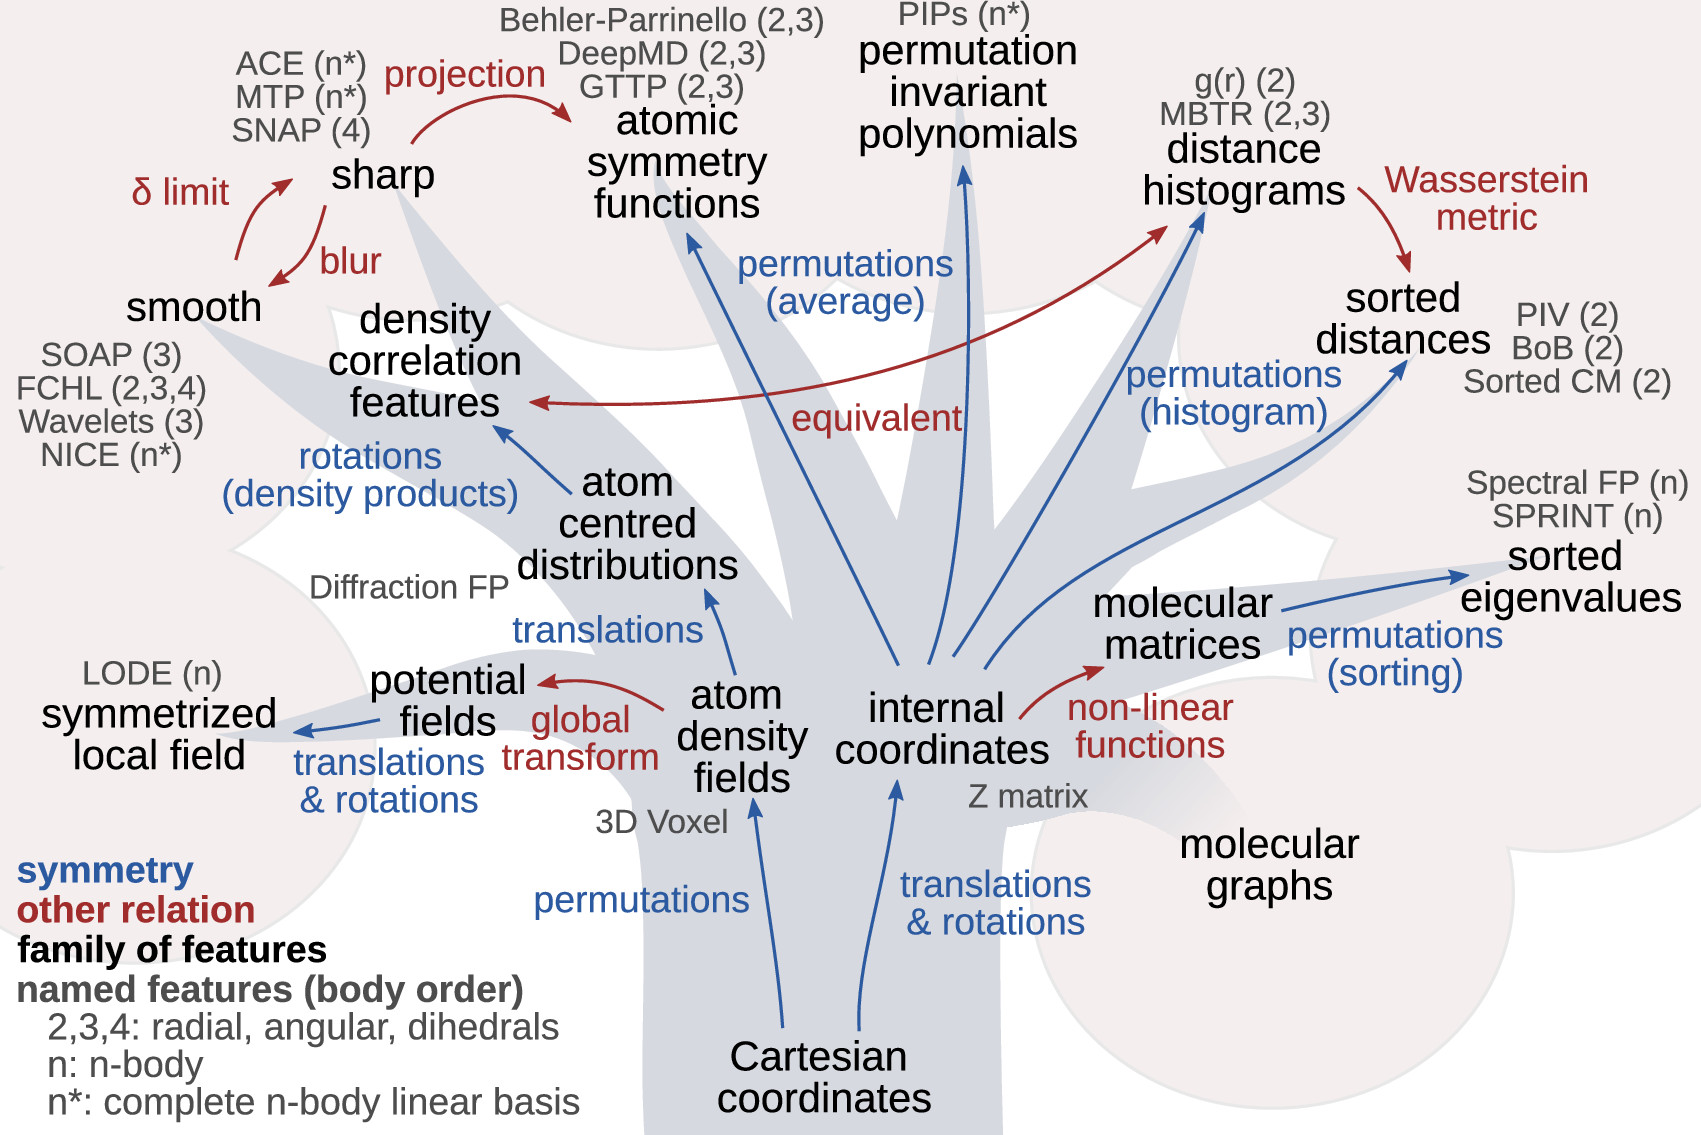

Chem. Rev. 2021, 121, 16, 9759–9815

# Complete basis: Atomic Cluster Expansion

### Classic Cluster Expansion

Let's choose a single-particle basis function $\phi$, which depends only on single bond vector, $\phi(\mathbf r_{ij})$

Orthonormal and complete:

$$ \langle \phi_{\nu} | \phi_v \rangle = \delta_{\nu v}$$
$$ \sum_{\nu} | \phi_{\nu}\rangle \langle \phi_{\nu} |  = \delta(r-r^{\prime})$$


Cluster basis function
$$ \Phi_{\nu}= \phi(\mathbf r_{ij_1})\phi(\mathbf r_{ij_2})\phi(\mathbf r_{ij_3})...$$

Atomic energy
$$E_i = \sum_{\nu} J_{\nu}\Phi_{\nu}$$

And the expansion coefficients are obtained by projection:
$$J_{\nu} = \langle \Phi_{\nu} | E_i \rangle$$

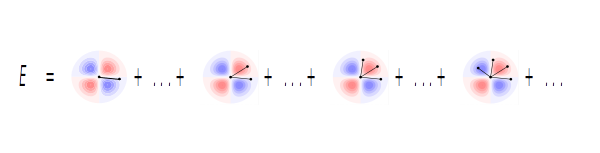

Scales exponentially with the number of neighbors

### Atomic Cluster Expansion

Instead, let's define the neighborhood density if atom $i$ of type $\mu_i$:
$$\Large \rho_i^{\mu_i}  = \sum_j^{j \neq i} \delta_{\mu \mu_j} \delta( \pmb{r} - \pmb{r}_{ji})$$

One-particle basis function:
$$\Large \phi_{\mu_i \mu_j nlm} = R_{nl}^{\mu_i\mu_j}(r_{ji}) Y_{lm}(\hat{\pmb r}_{ji})$$

Now, $atomic\, base$ is obtained by prejecting the neighborhood density onto the one-particle basis function:

$$ \Large A_{i\pmb v} = \langle {\rho_i^{\mu_i}} | {\phi_{\pmb v}} \rangle  = \sum_j \phi_{\pmb v}(\mathbf r_{ji}) $$

From atomic base we can build so-called $A-basis$:

$$ {\pmb A}_{i\mathbf{\pmb v}} = \prod_{t = 1}^{\nu} A_{i \mu_t n_t l_t m_t}$$


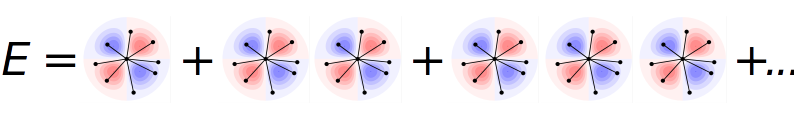

Scales linearly with the number of neighbors

Higher body-order basis functions as products of the projected neighborhood density

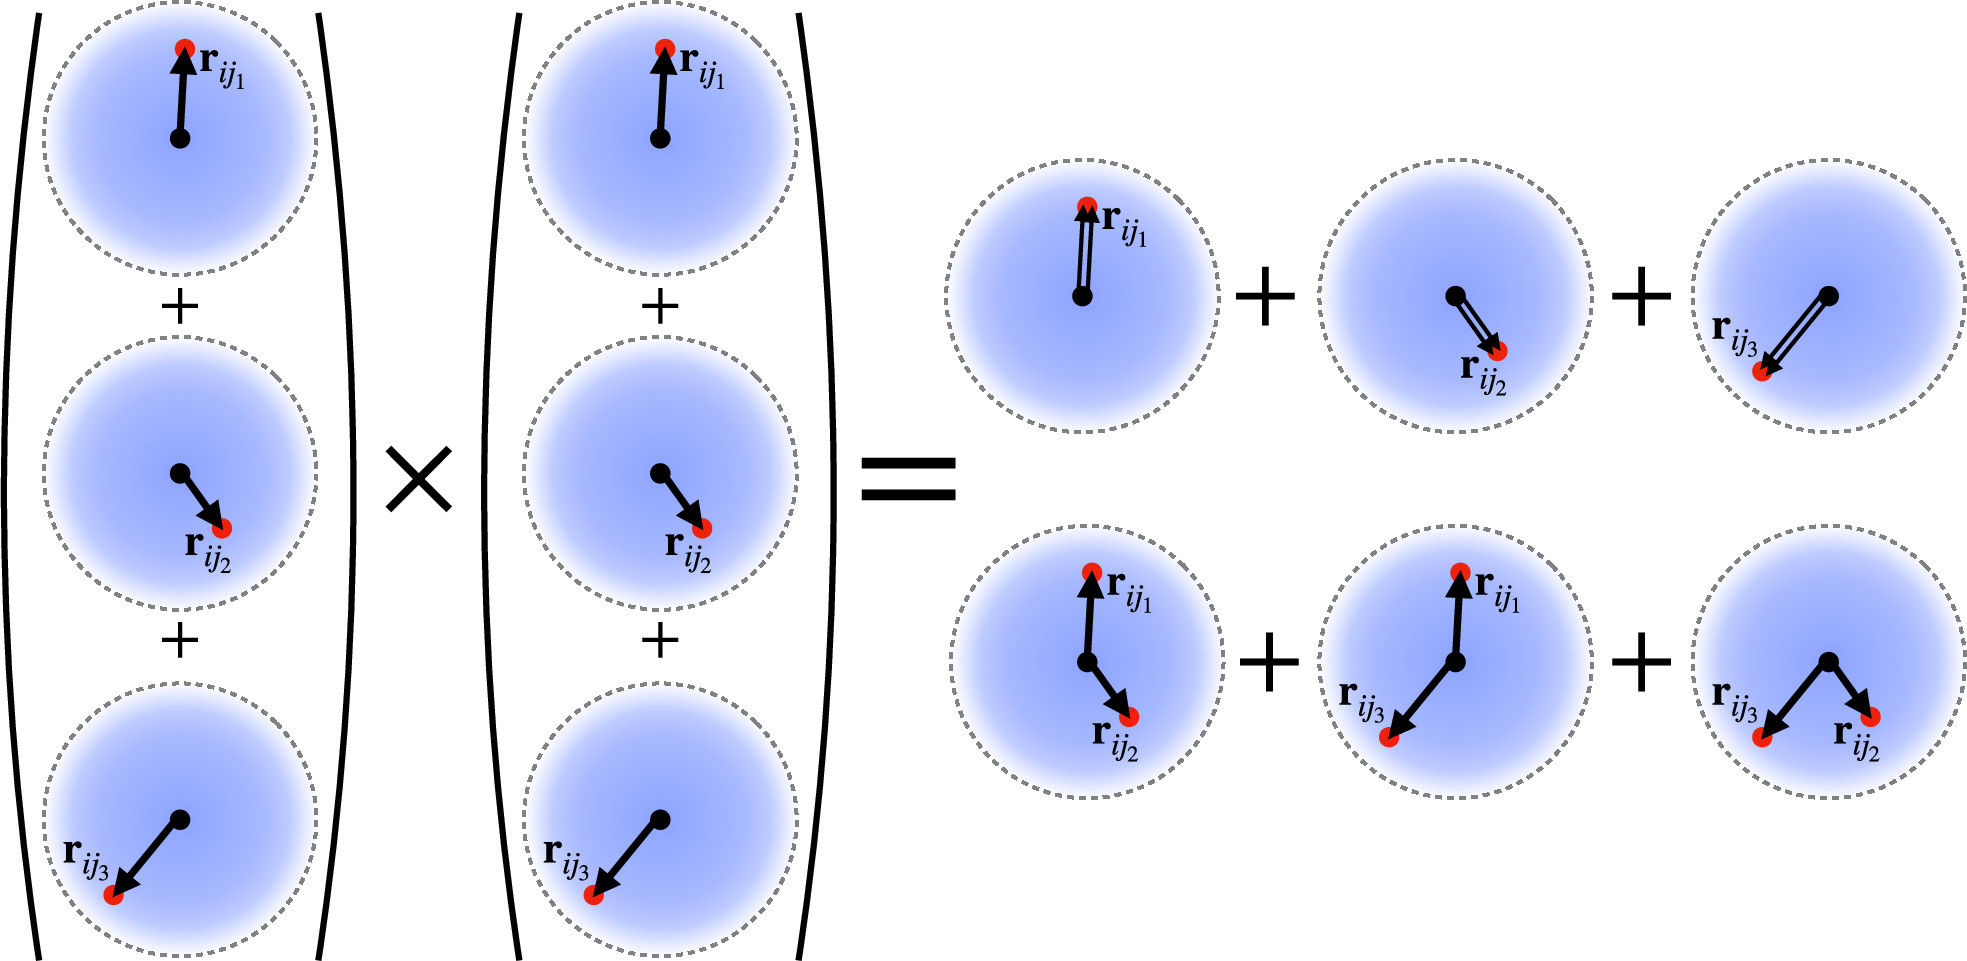

J. Chem. Theory Comput. 17, 12, 7696 (2021)

Rotation invariant basis functions:

$$ \Large \pmb B_{i \pmb v} = \sum_{\pmb v^{\prime}} C_{\pmb v \pmb v^{\prime}} {\pmb A}_{i\pmb v}$$

Atomic property:

$$\Large \varphi_i^{(p)} = \sum_{\pmb v} c_{\pmb v}^{(p)}  \pmb B_{i\pmb v}$$

Atomic energy:
$$ \Large E_i = \mathcal{F}(\varphi_i^{(1)}, \dots, \varphi_i^{(P)})$$

$$\large E_i =  \varphi_i^{(1)} + \sqrt{\varphi_i^{(2)}}$$

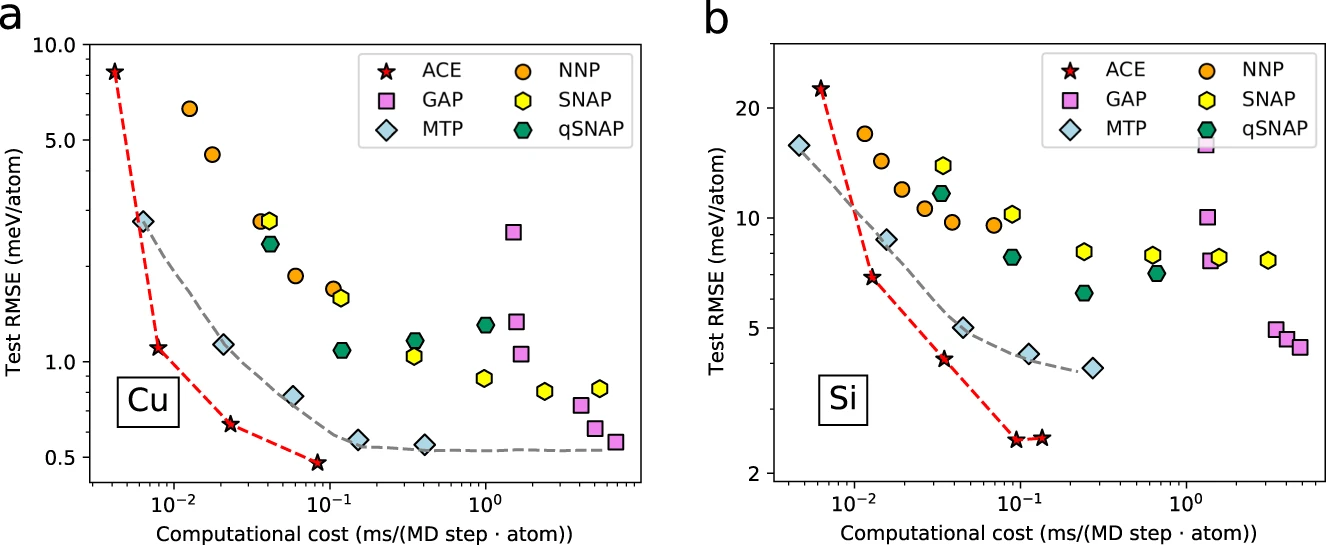

Pro:

- Complete basis

Con:

- Local*

Phys. Rev. B 99, 014104 (2019), Phys. Rev. B 102, 024104 (2020), npj Computational Materials 97 (2021), Phys. Rev. Materials 6, 013804 (2022)

https://github.com/ICAMS/python-ace

## Let's try to fit an ace potential

DFT data

In [ ]:
df = pd.read_pickle('./ace_fit/pd135_Cu_df2_1k.pkl.gzip', compression='gzip')

In [ ]:
df.head(5)

In [ ]:
df['volume_per_atom'] = df['ase_atoms'].map(lambda x: x.get_volume()/len(x))

In [ ]:
plt.figure(dpi=150)
plt.plot(df['volume_per_atom'], df['energy_corrected_per_atom'], 'o', ms=2)
plt.xlim(0, 50)
plt.xlabel('Volume per atom, A^3')
plt.ylabel('Energy per atom, eV/atom')

In [ ]:
! cd ace_fit/ ; pacemaker config_colab.yaml

Now performe some calculations:

In [ ]:
calc1 = PyACECalculator('./ace_fit/interim_potential_0.yaml')

In [ ]:
cu = bulk('Cu', 'fcc', a=3.8, cubic=True)

In [ ]:
configs = []
cell = cu.get_cell()
for x in np.linspace(0.85, 1.1, 21):
    cu_i = cu.copy()
    cu_i.set_calculator(calc1)
    cu_i.set_cell(cell * x, scale_atoms=True)
    cu_i.get_potential_energy()
    configs.append(cu_i)

In [ ]:
plt.figure(dpi=150)
volumes_fcc = np.array([at.get_volume() for at in configs])
energies_fcc = np.array([at.get_potential_energy() for at in configs])
eos = EquationOfState(volumes_fcc, energies_fcc, eos='birchmurnaghan')
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')
eos.plot();

In [ ]:
a0 = (eos.v0)**(1/3)
a0

In [ ]:
cu = bulk('Cu', 'bcc', a=3.0, cubic=True)
configs = []
cell = cu.get_cell()
for x in np.linspace(0.85, 1.1, 21):
    cu_i = cu.copy()
    cu_i.set_calculator(calc1)
    cu_i.set_cell(cell * x, scale_atoms=True)
    cu_i.get_potential_energy()
    configs.append(cu_i)

In [ ]:
plt.figure(dpi=150)
volumes_bcc = np.array([at.get_volume() for at in configs])
energies_bcc = np.array([at.get_potential_energy() for at in configs])
eos = EquationOfState(volumes_bcc, energies_bcc, eos='birchmurnaghan')
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')
eos.plot();

In [ ]:
a0 = (eos.v0)**(1/3)
a0

In [ ]:
plt.figure(dpi=150)
plt.plot(volumes_bcc/2, energies_bcc/2, 'o-', label='BCC')
plt.plot(volumes_fcc/4, energies_fcc/4, 'o-', label='FCC')
plt.legend()
plt.xlabel('Volume per atom, A^3')
plt.ylabel('Energy, eV/atom')

ACE basis functions

In [ ]:
cu = bulk('Cu', 'bcc', a=3.6, cubic=True)*(2,2,2)
#cu.positions += np.random.rand(len(cu), 3)
cu.set_calculator(calc1)
cu.get_potential_energy()
proj_bcc = calc1.projections

In [ ]:
cu = bulk('Cu', 'fcc', a=3.6, cubic=True)*(2,2,2)
#cu.positions += np.random.rand(len(cu), 3)
cu.set_calculator(calc1)
cu.get_potential_energy()
proj_fcc = calc1.projections

In [ ]:
proj_fcc.shape

In [ ]:
plt.figure(dpi=150)
plt.plot(proj_bcc[0], 'o-', label='BCC')
plt.plot(proj_fcc[0], 'o-', label='FCC')
plt.legend()
plt.xlabel('Basis function ind')
plt.ylabel('B-projection')
#plt.yscale('log')
plt.ylim(-10,20)